In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline

In [3]:
def pred_wind_power(windspeed_df, power_curve, temp_df=None, pressure_df=None):
    """Accepts dataframe with windspeeds (floats) at a certain location, Series with power produced at defined speeds.
    Returns DataFrame of 'Month' (1-12), output power ('kW'), in whatever timeframe submitted
    (eg. hourly, monthly, etc), assuming single 2MW turbine.
    Dependent on power_curve indexes equalling defined windspeed levels, and proper curve-class passed."""

    max_curve_speed = max(power_curve.index)
    windspeed = windspeed_df

    lower_ws = windspeed.apply(int).apply(lambda s: s if s < max_curve_speed else 0).values
    upper_ws = lower_ws+1
    power_diff = power_curve.iloc[upper_ws].reset_index(drop=True).sub(power_curve.iloc[lower_ws].reset_index(drop=True))
    frac_power = power_diff.mul(windspeed.sub(windspeed.apply(int)))
    final_power = frac_power.add(power_curve.iloc[lower_ws].reset_index(drop=True)).rename('kW')

    #return pd.concat([windspeed_df, final_power], axis=1)
    return final_power.sum(axis=0)

In [ ]:
#Get power curves
power_curves = pd.read_csv('/content/drive/MyDrive/Data Science Student Material/Capstone Project/Data/wind_power_curves.csv')
power_curves

In [5]:
file = '/content/drive/MyDrive/Data Science Student Material/Capstone Project/Data/test/all_wind.p'
dict_allData_read = pickle.load(open(file,'rb'))
wind_df = pd.DataFrame.from_dict(dict_allData_read)
del dict_allData_read

In [ ]:
wind_df

In [7]:
file = '/content/drive/MyDrive/Data Science Student Material/Capstone Project/Data/test/upper_south_pickle.p'
dict_allData_read = pickle.load(open(file,'rb'))
upper_south_df = pd.DataFrame.from_dict(dict_allData_read)
del dict_allData_read

In [ ]:
upper_south_df

In [8]:
file = '/content/drive/MyDrive/Data Science Student Material/Capstone Project/Data/test/bootheel_pickle.p'
dict_allData_read = pickle.load(open(file,'rb'))
bootheel_df = pd.DataFrame.from_dict(dict_allData_read)
del dict_allData_read

In [9]:
df = pd.DataFrame(columns=['lat', 'lon', 'energy'])

In [10]:
for el in wind_df.columns[5:]:
    tmp_df = pd.DataFrame({'lat': el.split('_')[0], 'lon': el.split('_')[1], 'energy': pred_wind_power(wind_df[el], power_curves['Class_2'])}, index=[0])
    df = pd.concat([df, tmp_df], axis=0, ignore_index=True)

In [11]:
for el in upper_south_df.columns[5:]:
    tmp_df = pd.DataFrame({'lat': el.split('_')[0], 'lon': el.split('_')[1], 'energy': pred_wind_power(upper_south_df[el], power_curves['Class_2'])}, index=[0])
    df = pd.concat([df, tmp_df], axis=0, ignore_index=True)

In [12]:
for el in bootheel_df.columns[5:]:
    tmp_df = pd.DataFrame({'lat': el.split('_')[0], 'lon': el.split('_')[1], 'energy': pred_wind_power(bootheel_df[el], power_curves['Class_2'])}, index=[0])
    df = pd.concat([df, tmp_df], axis=0, ignore_index=True)

In [13]:
df['energy'] = df['energy'].mul(0.82e-6)

In [14]:
wpower_df = df

In [ ]:
scl = [0,"rgb(100,255,255)"],[0.07,"rgb(100, 255, 255)"],[0.12,"rgb(100, 255, 255)"],\
[0.22,"rgb(151, 255, 140)"],[0.3,"rgb(151, 255, 80)"],[0.4,"rgb(151, 255, 0)"],\
[0.5,"rgb(255, 234, 0)"],[0.85,"rgb(255, 111, 0)"],[1,"rgb(255, 0, 0)"]

fig = go.Figure(data=go.Scattergeo(
    lat = wpower_df['lat'],
    lon = wpower_df['lon'],
    text = wpower_df['energy'].astype(str) + ' GWh',
    
    marker = dict(
        color = wpower_df['energy'],
        colorscale = scl,
        reversescale = False,
        opacity = 0.7,
        size = 5,
        colorbar = dict(
            titleside = "right",
            outlinecolor = "rgba(68, 68, 68, 0)",
            ticks = "outside",
            showticksuffix = "last",
            dtick = 1
        ),
        colorbar_title="Yearly Output(GWh)/2MW Turbine"
    )
))

fig.update_layout(
    geo = dict(
        scope = 'north america',
        showland = True,
        landcolor = "rgb(212, 212, 212)",
        subunitcolor = "rgb(255, 255, 255)",
        countrycolor = "rgb(255, 255, 255)",
        showlakes = False,
        lakecolor = "rgb(255, 255, 255)",
        showsubunits = True,
        showcountries = True,
        resolution = 50,
        projection = dict(
            type = 'conic conformal',
            rotation_lon = -100
        ),
        lonaxis = dict(
            showgrid = True,
            gridwidth = 0.5,
            range= [ -140.0, -55.0 ],
            dtick = 5
        ),
        lataxis = dict (
            showgrid = True,
            gridwidth = 0.5,
            range= [ 20.0, 60.0 ],
            dtick = 5
        )
    ),
    title='New Mexico Potential Wind Production',
)
fig.show()


In [15]:
def pred_solar_power(solar_df, station_rated_output):
    """Accepts dataframe with Global Horizontal Irradiance (floats) at a certain location in W/m^2,
    Scaler indicating output of plant in MW.
    ?Returns DataFrame of 'Month' (1-12), output power ('MW'), in whatever timeframe submitted
    """

    ghi = solar_df   # GHI in W/m^2

    pred_power = ghi.div(800).mul(station_rated_output).rename('MW')

    return pred_power.sum()

    #return pd.concat([solar_df, pred_power], axis=1)

In [16]:
file = '/content/drive/MyDrive/Data Science Student Material/Capstone Project/Data/all_solar.p'
dict_allData_read = pickle.load(open(file,'rb'))
solar_df = pd.DataFrame.from_dict(dict_allData_read)
del dict_allData_read

In [17]:
spower_df = pd.DataFrame(columns=['lat', 'lon', 'senergy'])

In [18]:
for el in solar_df.columns[5:]:
    tmp_df = pd.DataFrame({'lat': el.split('_')[0], 'lon': el.split('_')[1], 'senergy': pred_solar_power(solar_df[el], 2)}, index=[0])
    spower_df = pd.concat([spower_df, tmp_df], axis=0, ignore_index=True)

In [19]:
spower_df['senergy'] = spower_df['senergy']/1000

In [ ]:
spower_df

In [ ]:
df

In [133]:
# Matchup and merge wind & solar predictions

data = spower_df.merge(df, on=['lat', 'lon'])

In [134]:
data.shape

(4521, 4)

In [135]:
#from sklearn.preprocessing import normalize
#data_scaled = normalize(data[['senergy', 'energy']])
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[['senergy', 'energy']])
data_scaled = pd.DataFrame(data_scaled, columns=['senergy','energy'])
data_scaled.head()

senergy    energy
0  0.595537  0.645802
1  0.722246  0.313331
2  0.557299  0.587173
3  0.583552  0.566824
4  0.504429  0.496370

In [136]:
data

lat      lon   senergy    energy
0     32.41  -104.94  5.126623  6.647476
1     32.09  -104.98  5.255850  4.217714
2     32.53  -104.98  5.087625  6.219007
3     32.57  -104.98  5.114400  6.070295
4     32.77  -104.98  5.033705  5.555404
...     ...      ...       ...       ...
4516  34.41  -105.34  5.007627  6.732607
4517  34.41  -105.46  5.027572  7.370737
4518  34.41  -105.50  5.047285  7.085325
4519  34.41  -105.66  5.024235  6.833179
4520  34.41  -105.70  5.038597  6.775139

[4521 rows x 4 columns]

In [137]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=9, affinity='euclidean', linkage='ward')  
clusterNums = pd.Series(cluster.fit_predict(data_scaled)).rename('cluster')

In [138]:
clusterNums

0       3
1       5
2       6
3       6
4       1
       ..
4516    3
4517    3
4518    3
4519    3
4520    3
Name: cluster, Length: 4521, dtype: int64

In [139]:
data = pd.concat([data, clusterNums], axis=1)

In [140]:
pt_df = pd.pivot_table(data, index=['cluster'])

In [141]:
pt_df

energy   senergy
cluster                    
0        4.270471  4.834591
1        4.962121  4.996463
2        3.764136  5.194369
3        6.960635  4.973622
4        5.875952  4.726679
5        4.733135  5.310565
6        5.583559  5.111133
7        6.154342  4.912610
8        3.719693  4.940309

In [155]:
"""
scl = [0,"rgb(100,255,255)"],[0.07,"rgb(100,255,255)"],[0.12,"rgb(100,255,255)"],\
[0.22,"rgb(66,255,180)"],[0.3,"rgb(44, 255, 80)"],[0.4,"rgb(151, 255, 0)"],\
[0.5,"rgb(255, 234, 0)"],[0.85,"rgb(255, 111, 0)"],[1,"rgb(255, 0, 0)"]
"""
scl = [0,"rgb(0,130,255)"],[0.5,"rgb(255,255,0)"],[1,"rgb(255,0,0)"]

fig = go.Figure(data=go.Scattergeo(
    lat = data['lat'],
    lon = data['lon'],
    text = 'Cluster ' + data['cluster'].astype(str),
    
    marker = dict(
        color = data['cluster2'],
        colorscale = scl,
        reversescale = False,
        opacity = 0.7,
        size = 7,
        colorbar = dict(
            titleside = "right",
            outlinecolor = "rgba(68, 68, 68, 0)",
            ticks = "outside",
            showticksuffix = "last",
            dtick = 1
        ),
        colorbar_title="Cluster"
    )
))

fig.update_layout(
    geo = dict(
        scope = 'north america',
        showland = True,
        landcolor = "rgb(212, 212, 212)",
        subunitcolor = "rgb(255, 255, 255)",
        countrycolor = "rgb(255, 255, 255)",
        showlakes = False,
        lakecolor = "rgb(255, 255, 255)",
        showsubunits = True,
        showcountries = True,
        resolution = 50,
        projection = dict(
            type = 'conic conformal',
            rotation_lon = -100
        ),
        lonaxis = dict(
            showgrid = True,
            gridwidth = 0.5,
            range= [ -140.0, -55.0 ],
            dtick = 5
        ),
        lataxis = dict (
            showgrid = True,
            gridwidth = 0.5,
            range= [ 20.0, 60.0 ],
            dtick = 5
        )
    ),
    #title='Wind+Solar Production Potential',
)
fig.show()


In [143]:
data_scaled['cluster'] = data['cluster']

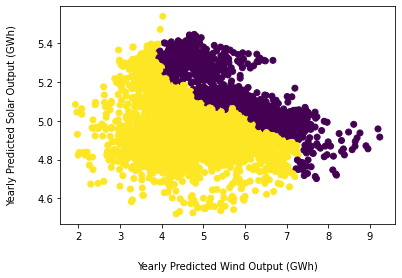

In [154]:
#plt.scatter(data_scaled['energy'], data_scaled['senergy'], c=data_scaled['cluster']);
plt.scatter(data['energy'], data['senergy'], c=data['cluster2']);

#plt.title(label='Wind+Solar Potential Grouping', pad=30)
plt.xlabel('Yearly Predicted Wind Output (GWh)', labelpad=20)
plt.ylabel('Yearly Predicted Solar Output (GWh)', labelpad=20);

In [145]:
data['cluster2'] = 0

In [152]:
#data.cluster2[data['cluster'].isin([3,5,6])] = 1
data.cluster2[data['cluster'].isin([0,1,2,4,7,8])] = 2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [153]:
data

lat      lon   senergy    energy  cluster  cluster2
0     32.41  -104.94  5.126623  6.647476        3         1
1     32.09  -104.98  5.255850  4.217714        5         1
2     32.53  -104.98  5.087625  6.219007        6         1
3     32.57  -104.98  5.114400  6.070295        6         1
4     32.77  -104.98  5.033705  5.555404        1         2
...     ...      ...       ...       ...      ...       ...
4516  34.41  -105.34  5.007627  6.732607        3         1
4517  34.41  -105.46  5.027572  7.370737        3         1
4518  34.41  -105.50  5.047285  7.085325        3         1
4519  34.41  -105.66  5.024235  6.833179        3         1
4520  34.41  -105.70  5.038597  6.775139        3         1

[4521 rows x 6 columns]